In [ ]:
#Step 6: Merge CNN-LSTM Forecasting result and RL Trading Model

Epoch 1: Loss = 0.4623
Epoch 2: Loss = 0.4545
Epoch 3: Loss = 0.4532
Epoch 4: Loss = 0.4519
Epoch 5: Loss = 0.4512
Epoch 6: Loss = 0.4504
Epoch 7: Loss = 0.4498
Epoch 8: Loss = 0.4490
Epoch 9: Loss = 0.4480
Epoch 10: Loss = 0.4472


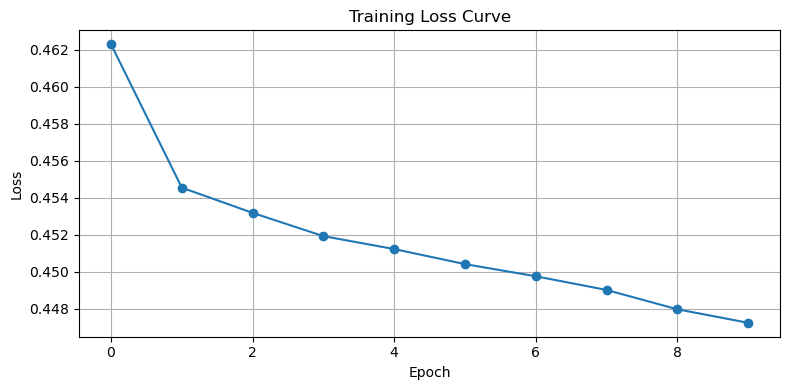

Test Accuracy: 81.94%
Epoch 1: Loss = 0.4635
Epoch 2: Loss = 0.4574
Epoch 3: Loss = 0.4557
Epoch 4: Loss = 0.4546
Epoch 5: Loss = 0.4535
Epoch 6: Loss = 0.4527
Epoch 7: Loss = 0.4521
Epoch 8: Loss = 0.4518
Epoch 9: Loss = 0.4506
Epoch 10: Loss = 0.4502
Test Accuracy: 81.86%


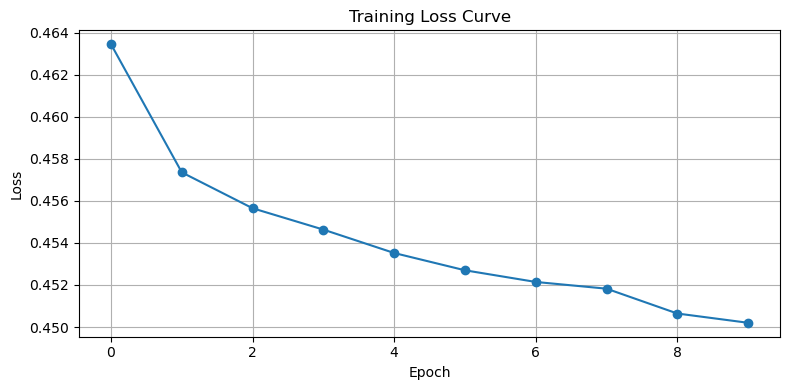

Epoch 1: Train Loss = 0.4645, Val Loss = 0.4548, Val Acc = 81.92%
Epoch 2: Train Loss = 0.4575, Val Loss = 0.4533, Val Acc = 81.91%
Epoch 3: Train Loss = 0.4556, Val Loss = 0.4493, Val Acc = 81.91%
Epoch 4: Train Loss = 0.4545, Val Loss = 0.4511, Val Acc = 81.91%
Epoch 5: Train Loss = 0.4537, Val Loss = 0.4591, Val Acc = 81.92%
Epoch 6: Train Loss = 0.4531, Val Loss = 0.4491, Val Acc = 81.87%
Epoch 7: Train Loss = 0.4520, Val Loss = 0.4490, Val Acc = 81.92%
Epoch 8: Train Loss = 0.4518, Val Loss = 0.4479, Val Acc = 81.97%
Epoch 9: Train Loss = 0.4507, Val Loss = 0.4469, Val Acc = 81.84%
Epoch 10: Train Loss = 0.4499, Val Loss = 0.4504, Val Acc = 81.89%
Epoch 11: Train Loss = 0.4496, Val Loss = 0.4487, Val Acc = 81.88%
Epoch 12: Train Loss = 0.4483, Val Loss = 0.4532, Val Acc = 81.51%
Epoch 13: Train Loss = 0.4479, Val Loss = 0.4530, Val Acc = 81.86%
Epoch 14: Train Loss = 0.4468, Val Loss = 0.4499, Val Acc = 81.66%
Early stopping triggered!


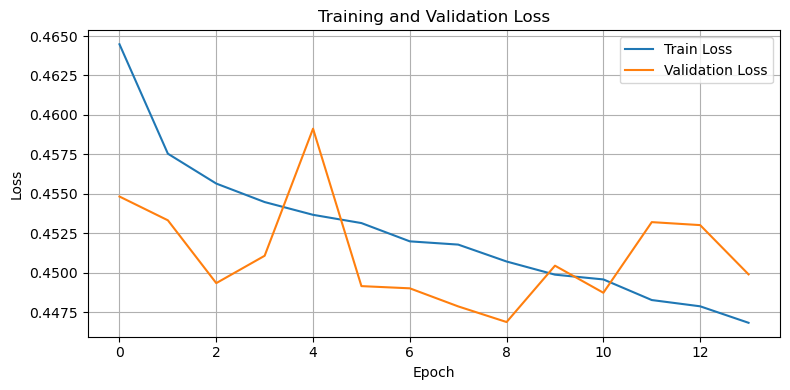

In [1]:
# Cote CNN-LSTM Model
#!/usr/bin/env python
# coding: utf-8

get_ipython().system('pip install pandas numpy scikit-learn torch matplotlib')
get_ipython().system('pip install ta')

# Load Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator  
from ta.trend import MACD, EMAIndicator
from ta.volatility import BollingerBands
df = pd.read_csv(r"C:\Users\24716\Downloads\cleaned_crypto_data.csv")
features_cols = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDT', 'price_change', 'price_range', 'vwap']

# Create tech features
df["rsi_14"] = RSIIndicator(close=df["close"], window=14).rsi()
macd = MACD(close=df["close"])
df["macd"] = macd.macd()
df["macd_signal"] = macd.macd_signal()
df["ema_5"] = EMAIndicator(close=df["close"], window=5).ema_indicator()
df["ema_20"] = EMAIndicator(close=df["close"], window=20).ema_indicator()
bb = BollingerBands(close=df["close"], window=20)
df["bb_upper"] = bb.bollinger_hband()
df["bb_middle"] = bb.bollinger_mavg()
df["bb_lower"] = bb.bollinger_lband()
df["momentum_10"] = df["close"] - df["close"].shift(10)

# Preprocess
future_close = df['close'].shift(-1)
df['label'] = (future_close > df['close']).astype(int)
df.dropna(inplace=True)

features_cols = [
    'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDT',
    'price_change', 'price_range', 'vwap',
    'rsi_14', 'macd', 'macd_signal',
    'ema_5', 'ema_20',
    'bb_upper', 'bb_middle', 'bb_lower',
    'momentum_10'
]

features = df[features_cols].values
labels = df['label'].values

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


def create_sequences(features, labels, window=24):
    X, y = [], []
    for i in range(len(features) - window):
        X.append(features[i:i+window].astype(np.float32))
        y.append(labels[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(features_scaled[-100000:], labels[-100000:], window=24)

# Dataset Split 
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# Define Model 
class LSTMTrader(nn.Module):
    def __init__(self, input_size=9, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMTrader(input_size=X.shape[2])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []

for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb).argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

print(f"Test Accuracy: {correct / total:.2%}")


#Regularized LSTM
class RegularizedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  
        out = self.norm(out)
        out = self.dropout(out)
        return self.fc(out)


model = RegularizedLSTM(input_size=X.shape[2])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, patience_counter = 5, 0

for epoch in range(30):
    # Train
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()
            correct += (pred.argmax(dim=1) == yb).sum().item()
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    val_acc = correct / len(test_ds)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.2%}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

#Exact model forcasting results
import torch

model.eval()
with torch.no_grad():
    test_X_tensor = torch.tensor(X_test)
    preds = model(test_X_tensor)
    predicted_labels = preds.argmax(dim=1).numpy()  #Predict Result: 0 or 1
close_series = df['close'].values
offset = len(close_series) - len(X)
close_test = close_series[offset + split:]



Epoch 1: Train Loss = 0.4636, Val Loss = 0.4612, Val Acc = 81.93%
Epoch 2: Train Loss = 0.4572, Val Loss = 0.4536, Val Acc = 81.90%
Epoch 3: Train Loss = 0.4558, Val Loss = 0.4523, Val Acc = 81.94%
Epoch 4: Train Loss = 0.4545, Val Loss = 0.4488, Val Acc = 81.91%
Epoch 5: Train Loss = 0.4538, Val Loss = 0.4510, Val Acc = 81.91%
Epoch 6: Train Loss = 0.4523, Val Loss = 0.4500, Val Acc = 81.91%
Epoch 7: Train Loss = 0.4514, Val Loss = 0.4522, Val Acc = 81.91%
Epoch 8: Train Loss = 0.4510, Val Loss = 0.4484, Val Acc = 81.91%
Epoch 9: Train Loss = 0.4502, Val Loss = 0.4505, Val Acc = 81.86%
Epoch 10: Train Loss = 0.4495, Val Loss = 0.4478, Val Acc = 81.84%
Epoch 11: Train Loss = 0.4488, Val Loss = 0.4478, Val Acc = 81.86%
Epoch 12: Train Loss = 0.4483, Val Loss = 0.4489, Val Acc = 81.89%
Epoch 13: Train Loss = 0.4474, Val Loss = 0.4494, Val Acc = 81.70%
Epoch 14: Train Loss = 0.4467, Val Loss = 0.4513, Val Acc = 81.84%
Epoch 15: Train Loss = 0.4454, Val Loss = 0.4514, Val Acc = 81.76%
Earl

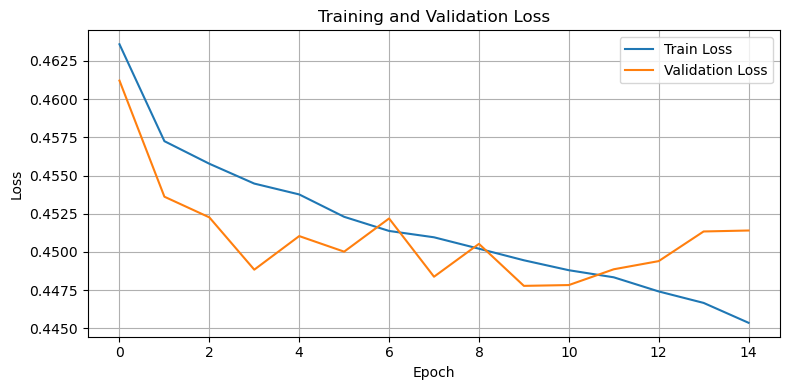

In [2]:
#Establish Model
import torch.nn as nn

#Regularized LSTM
class RegularizedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  
        out = self.norm(out)
        out = self.dropout(out)
        return self.fc(out)


model = RegularizedLSTM(input_size=X.shape[2])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, patience_counter = 5, 0

for epoch in range(30):
    # Train
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()
            correct += (pred.argmax(dim=1) == yb).sum().item()
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    val_acc = correct / len(test_ds)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.2%}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Loss Curve Visualization
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Exact model forcasting results
import torch

model.eval()
with torch.no_grad():
    test_X_tensor = torch.tensor(X_test)
    preds = model(test_X_tensor)
    predicted_labels = preds.argmax(dim=1).numpy()  #Predict Result: 0 or 1
close_series = df['close'].values
offset = len(close_series) - len(X)
close_test = close_series[offset + split:]
model = RegularizedLSTM(input_size=18)

model.cpu()
model.eval()


torch.save(model, "lstm_model_cpu_full.pth")

In [29]:
#Download Signal and form into new csv document 

# offset is the starting offset of the LSTM sliding window
offset = len(close_series) - len(X)

# Write the LSTM signal into df
df.loc[offset + split:, "lstm_signal"] = predicted_labels

# Clean the data (if there are too many NaNs in the front)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Save data file with signal for PPO use
df.to_csv("cleaned_crypto_data_with_lstm_signal.csv", index=False)
print("Data file with LSTM prediction signal saved")

✅ 已保存带 LSTM 预测信号的数据文件


In [31]:
# Cote RL Trading Model

import gym
import numpy as np
import pandas as pd
from gym import spaces
from ta.momentum import RSIIndicator
from ta.trend import MACD, EMAIndicator
from ta.volatility import BollingerBands
from sklearn.preprocessing import StandardScaler


class TradingEnv(gym.Env):
  
    def __init__(self, df, window_size=24):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.window_size = window_size

        
        self.features = self._build_features(self.df)
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)

   
        self.valid_length = len(self.features)
        self.max_steps = self.valid_length - self.window_size - 1

     
        obs_shape = (window_size, self.features.shape[1])
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=obs_shape, dtype=np.float32)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

    
        self.reset()

    def _build_features(self, df):
        df = df.copy()
        df["rsi"] = RSIIndicator(close=df["close"], window=14).rsi()
        macd = MACD(close=df["close"])
        df["macd"] = macd.macd()
        df["macd_signal"] = macd.macd_signal()
        df["ema_5"] = EMAIndicator(close=df["close"], window=5).ema_indicator()
        df["ema_20"] = EMAIndicator(close=df["close"], window=20).ema_indicator()
        bb = BollingerBands(close=df["close"], window=20)
        df["bb_upper"] = bb.bollinger_hband()
        df["bb_middle"] = bb.bollinger_mavg()
        df["bb_lower"] = bb.bollinger_lband()
        df["momentum"] = df["close"] - df["close"].shift(10)
        df = df.dropna()
        return df[["open", "high", "low", "close", "Volume BTC", "rsi", "macd", "macd_signal",
                  "ema_5", "ema_20", "bb_upper", "bb_middle", "bb_lower", "momentum", "lstm_signal"]] #lstm_signal as the feature we generate from CNN-LSTM Model

    def reset(self):
        self.step_idx = 0
        self.position = 0.0  
        self.cash = 1.0      
        self.asset_value = 1.0
        self.history = []
        return self._get_observation()
    def _get_observation(self):
        obs = self.features[self.step_idx:self.step_idx + self.window_size]
        if obs.shape[0] < self.window_size:
            pad_length = self.window_size - obs.shape[0]
            padding = np.zeros((pad_length, self.features.shape[1]))
            obs = np.vstack((obs, padding))
        
        assert obs.shape == (self.window_size, self.features.shape[1]), \
        f"Obs shape mismatch: {obs.shape} != {(self.window_size, self.features.shape[1])}"
        return obs.astype(np.float32)

    def step(self, action):
        action = np.clip(action[0], 0.0, 1.0)
        current_price = self.df["close"].iloc[self.step_idx + self.window_size - 1]
        next_price = self.df["close"].iloc[self.step_idx + self.window_size]
        return_rate = (next_price - current_price) / current_price
        
        self.position = action
        portfolio_return = self.position * return_rate
        self.asset_value *= (1 + portfolio_return)
        
        reward = portfolio_return
        self.step_idx += 1
        done = self.step_idx >= self.max_steps
        
        if done:
            obs = np.zeros_like(self._get_observation())  
        else:
            obs = self._get_observation()
        info = {"asset_value": self.asset_value}
        return obs, reward, done, info

    def render(self):
        print(f"Step: {self.step_idx}, Value: {self.asset_value:.4f}, Position: {self.position:.2f}")


In [37]:
# Cote PPO Trading Model

!pip install shimmy>=2.0
!pip install gymnasium
import gymnasium as gym
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv



raw_df = pd.read_csv("cleaned_crypto_data_with_lstm_signal.csv")


def make_env():
    return TradingEnv(raw_df)

env = DummyVecEnv([make_env])


model = PPO(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    tensorboard_log="./ppo_logs/",
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
)


model.learn(total_timesteps=50_000)


model.save("ppo_trading_agent")
print("PPO Agent has been saved as ppo_trading_agent.zip")

Using cpu device
Logging to ./ppo_logs/PPO_1


C:\Users\24716\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 968  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 629          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0058576725 |
|    clip_fraction        | 0.0351       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -6.91        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00981     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0067      |
|    std                  | 1            |
|    value_loss           | 0.00862      |
----------------

C:\Users\24716\AppData\Local\Temp\ipykernel_4024\3621805869.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "signal": float(action[0])


✅ 策略信号与资产记录保存为 ppo_trading_log.csv


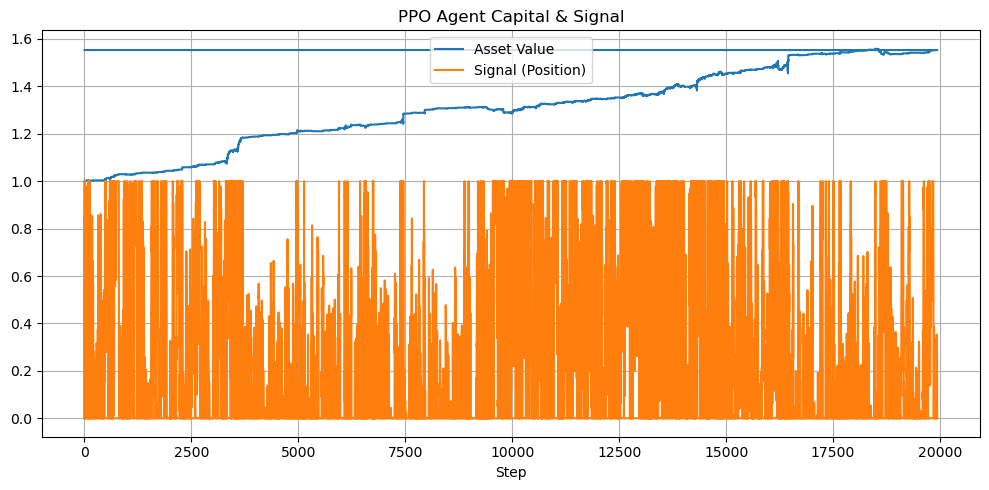

In [39]:
#Record Training Result and Visualization
obs = env.reset()
done = False
log = []

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)

    log.append({
        "step": env.envs[0].step_idx,
        "position": env.envs[0].position,
        "reward": reward[0],
        "asset_value": info[0]["asset_value"],
        "signal": float(action[0])
    })

    if done[0]:
        break

log_df = pd.DataFrame(log)
log_df.to_csv("ppo_trading_log.csv", index=False)
print("The strategy signals and asset records are saved as ppo_trading_log.csv")
import pandas as pd
import matplotlib.pyplot as plt

#Visualization
log_df = pd.read_csv("ppo_trading_log.csv")

plt.figure(figsize=(10, 5))
plt.plot(log_df["step"], log_df["asset_value"], label="Asset Value")
plt.plot(log_df["step"], log_df["signal"], label="Signal (Position)")
plt.title("PPO Agent Capital & Signal")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()